In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


In [3]:
from dateutil.relativedelta import relativedelta
from datetime import datetime


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:

def calculate_one_year_earlier_1(most_recent_date_row):
    
    most_recent_date_string = most_recent_date_row.date
    print( type(most_recent_date_string) ) 
    print(most_recent_date_string)
    
    print("")
        
    # Parse the string into a datetime object
    # most_recent_date = datetime.strptime(most_recent_date_string, "%Y-%m-%d")
    most_recent_date = datetime.strptime(most_recent_date_string, "%Y-%m-%d")
    print( type(most_recent_date) ) 
    print(most_recent_date)
    
    print("")
    
    
    one_year_earlier = most_recent_date - relativedelta(years=1)
    print( type(one_year_earlier) ) 
    print(one_year_earlier)
    
    print("")
    
    # Convert the datetime object to a string in the format "%Y-%m-%d"
    one_year_earlier_date_string = one_year_earlier.strftime("%Y-%m-%d")
    print( type(one_year_earlier_date_string) )
    print(one_year_earlier_date_string)

    return one_year_earlier_date_string


In [6]:

def calculate_one_year_earlier_2(most_recent_date_row):
        
    # Convert the string date to a datetime object
#    most_recent_date = datetime.strptime(most_recent_date_row['date'], '%Y-%m-%d')
    most_recent_date = datetime.strptime(most_recent_date_row.date, '%Y-%m-%d')

    print( type(most_recent_date) ) 
    print(most_recent_date)
    
    # Calculate the date one year earlier
    one_year_earlier_date = most_recent_date - relativedelta(years=1)

    print("")
    print( type(one_year_earlier_date) ) 
    print(one_year_earlier_date)

    # Convert the date back to a string
    one_year_earlier_date_string = one_year_earlier_date.strftime('%Y-%m-%d')

    print("")
    print( type(one_year_earlier_date_string) )
    print(one_year_earlier_date_string)
    
    return one_year_earlier_date_string


In [7]:

def calculate_one_year_earlier_3(most_recent_date_string):
        
    # Convert the string date to a datetime object
#    most_recent_date = datetime.strptime(most_recent_date_row['date'], '%Y-%m-%d')
    most_recent_date = datetime.strptime(most_recent_date_string, '%Y-%m-%d')

    print( type(most_recent_date) ) 
    print(most_recent_date)
    
    # Calculate the date one year earlier
    one_year_earlier_date = most_recent_date - relativedelta(years=1)

    print("")
    print( type(one_year_earlier_date) ) 
    print(one_year_earlier_date)

    # Convert the date back to a string
    one_year_earlier_date_string = one_year_earlier_date.strftime('%Y-%m-%d')

    print("")
    print( type(one_year_earlier_date_string) )
    print(one_year_earlier_date_string)
    
    return one_year_earlier_date_string


In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# # View all of the classes that automap found
# Base.classes.keys()
#

['measurement', 'station']

In [11]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
# Display the first row's columns and data in dictionary format
first_row = session.query(station).first()
print( first_row.__dict__ )

# Display the first row's columns and data in dictionary format
first_row = session.query(measurement).first()
print( first_row.__dict__ )


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000023327857CA0>, 'longitude': -157.8168, 'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US', 'latitude': 21.2716, 'id': 1, 'elevation': 3.0}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000233278B2D40>, 'prcp': 0.08, 'id': 1, 'tobs': 65.0, 'station': 'USC00519397', 'date': '2010-01-01'}


In [14]:
# Display the first row's columns and data in dictionary format
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x233278b2920>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [15]:
# Display the first row's columns and data in dictionary format
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x233278b0e80>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.

#most_recent_date_row = session.query(measurement.date).order_by(desc(measurement.date)).first()

most_recent_date_row = session.query(
    measurement.date
).order_by(
    measurement.date.desc()
).first()

print( type(most_recent_date_row) ) 
print(most_recent_date_row)


<class 'sqlalchemy.engine.row.Row'>
('2017-08-23',)


In [17]:

print( type(most_recent_date_row) ) 
print(most_recent_date_row)

print("----------")

one_year_earlier_date_string = calculate_one_year_earlier_1(most_recent_date_row)

print("----------")

print( type(one_year_earlier_date_string) )
print(one_year_earlier_date_string)


<class 'sqlalchemy.engine.row.Row'>
('2017-08-23',)
----------
<class 'str'>
2017-08-23

<class 'datetime.datetime'>
2017-08-23 00:00:00

<class 'datetime.datetime'>
2016-08-23 00:00:00

<class 'str'>
2016-08-23
----------
<class 'str'>
2016-08-23


In [18]:

print( type(most_recent_date_row) ) 
print(most_recent_date_row)

print("----------")

one_year_earlier_date_string = calculate_one_year_earlier_2(most_recent_date_row)

print("----------")

print( type(one_year_earlier_date_string) )
print(one_year_earlier_date_string)


<class 'sqlalchemy.engine.row.Row'>
('2017-08-23',)
----------
<class 'datetime.datetime'>
2017-08-23 00:00:00

<class 'datetime.datetime'>
2016-08-23 00:00:00

<class 'str'>
2016-08-23
----------
<class 'str'>
2016-08-23


In [19]:

print( type(most_recent_date_row) ) 
print(most_recent_date_row)

print( type(most_recent_date_row.date) ) 
print(most_recent_date_row.date)

print("----------")

one_year_earlier_date_string = calculate_one_year_earlier_3(most_recent_date_row.date)

print("----------")

print( type(one_year_earlier_date_string) )
print(one_year_earlier_date_string)


<class 'sqlalchemy.engine.row.Row'>
('2017-08-23',)
<class 'str'>
2017-08-23
----------
<class 'datetime.datetime'>
2017-08-23 00:00:00

<class 'datetime.datetime'>
2016-08-23 00:00:00

<class 'str'>
2016-08-23
----------
<class 'str'>
2016-08-23


In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_earlier_date_string = calculate_one_year_earlier_3(most_recent_date_row.date)


# Perform a query to retrieve the data and precipitation scores
# measurements = session.query(measurement.prcp, measurement.date).\
#     filter(measurement.date >= one_year_earlier_date_string).\
#     all()


# Perform a query to retrieve the data and precipitation scores
measurements = session.query(
    measurement.prcp, measurement.date
).filter(
    measurement.date >= one_year_earlier_date_string
).all()


print("")
print (measurements)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(measurements, columns=['Precipitation','Date'])

print("")
print (df)

# Sort the dataframe by date
df_sorted = df.sort_values(by='Date', ascending=True)

print("")
print (df_sorted)


<class 'datetime.datetime'>
2017-08-23 00:00:00

<class 'datetime.datetime'>
2016-08-23 00:00:00

<class 'str'>
2016-08-23

[(0.0, '2016-08-23'), (0.08, '2016-08-24'), (0.08, '2016-08-25'), (0.0, '2016-08-26'), (0.0, '2016-08-27'), (0.01, '2016-08-28'), (0.0, '2016-08-29'), (0.0, '2016-08-30'), (0.13, '2016-08-31'), (0.0, '2016-09-01'), (0.0, '2016-09-02'), (0.0, '2016-09-03'), (0.03, '2016-09-04'), (None, '2016-09-05'), (None, '2016-09-06'), (0.05, '2016-09-07'), (0.0, '2016-09-08'), (0.03, '2016-09-09'), (0.0, '2016-09-10'), (0.05, '2016-09-11'), (0.0, '2016-09-12'), (0.02, '2016-09-13'), (1.32, '2016-09-14'), (0.42, '2016-09-15'), (0.06, '2016-09-16'), (0.05, '2016-09-17'), (0.0, '2016-09-18'), (0.0, '2016-09-19'), (0.0, '2016-09-20'), (0.0, '2016-09-21'), (0.02, '2016-09-22'), (0.0, '2016-09-23'), (0.0, '2016-09-24'), (0.0, '2016-09-25'), (0.06, '2016-09-26'), (0.02, '2016-09-27'), (0.0, '2016-09-28'), (0.0, '2016-09-29'), (0.0, '2016-09-30'), (0.0, '2016-10-01'), (0.0, '2016-10-02

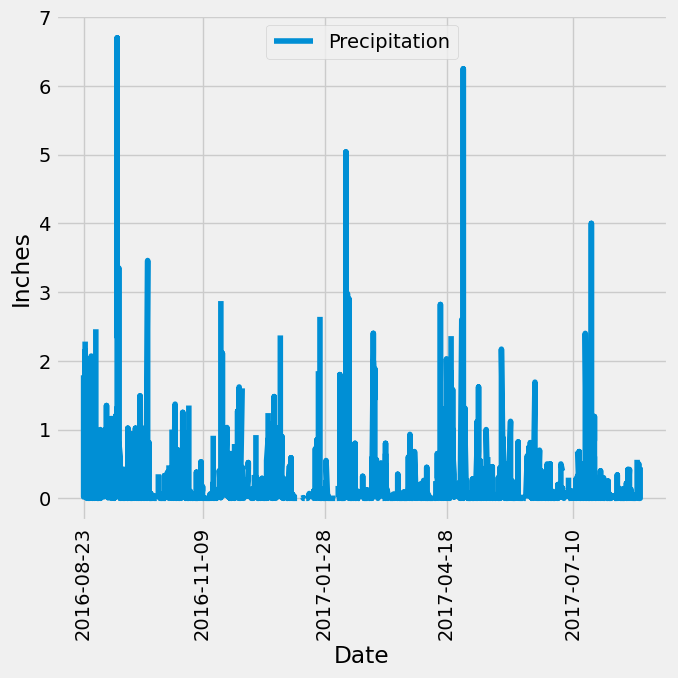

In [21]:

# Use Pandas Plotting with Matplotlib to plot the data

df_sorted["Date"]=pd.to_datetime(df_sorted["Date"])

#custom_dates = ["2016-08-23", "2016-10-01", "2016-11-09", "2016-12-19", "2017-01-28", "2017-03-09", "2017-04-18", "2017-05-31", "2017-07-10"]
custom_dates = ["2016-08-23", "2016-11-09", "2017-01-28", "2017-04-18", "2017-07-10"]

plt.figure(figsize=(7,7))
plt.plot(df_sorted['Date'], df_sorted['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
#plt.title('Precipitation Data')
plt.xticks(custom_dates, rotation=90)
# plt.xticks(rotation=90)
plt.legend(loc='upper center')
plt.tight_layout()

plt.show()


In [22]:
print( 
    type(
        df_sorted['Precipitation'].describe()
    )
)

print(
    type(
        pd.DataFrame(
            df_sorted['Precipitation'].describe()
        )
    )
)


pd.DataFrame(
    df_sorted['Precipitation'].describe()
)


<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Text(0, 0.5, 'Inches')

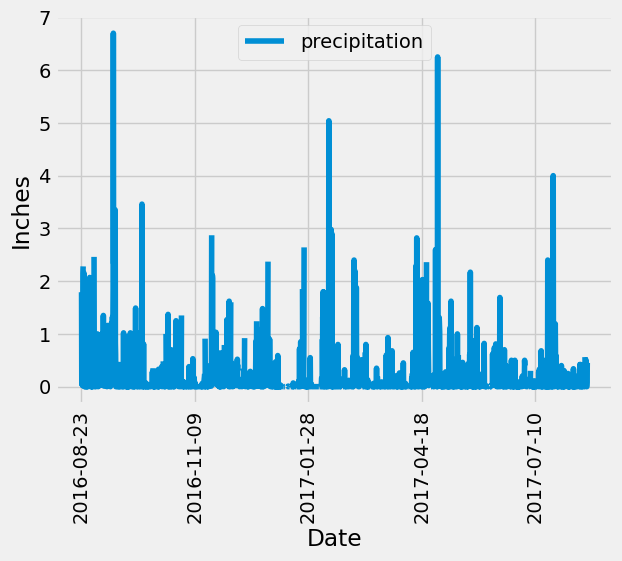

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# stations = session.query(station.id, station.station).\
#     all()
# print( type(stations) ) 
# stations

In [24]:
# stations = session.query(station).count()
# stations

In [25]:
# # Design a query to calculate the total number of stations in the dataset

# stations = session.query(station.station).group_by(station.station).count()
# print( type(stations) ) 
# stations

In [26]:
# stations = session.query(station.station).distinct().count()
# print( type(stations) ) 
# stations

In [27]:
# stations = session.query(func.count(func.distinct(station.station))).scalar()
# print( type(stations) ) 
# stations

In [28]:
# Design a query to calculate the total number of stations in the dataset

#stations = session.query(func.count(func.distinct(station.station))).all()

stations = session.query(
    func.count(
        func.distinct(station.station)
    )
).all()

print( type(stations) ) 
stations

<class 'list'>


[(9,)]

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# station_activity = session.query(measurement.station,\
#     func.count(measurement.station)).\
#     group_by(measurement.station).\
#     order_by(func.count(measurement.station).desc())\
#     .all()

station_activity = session.query(
    measurement.station, func.count(measurement.station)
).group_by(
    measurement.station
).order_by(
    func.count(measurement.station).desc()
).all()

# print( type(station_activity) ) 

# for station, count in station_activity:
#     print(f"{station},{count}")

# print( station_activity )

# for stationcount in station_activity:
#     print(stationcount)

station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = station_activity[0][0]

# summary_station_activity = session.query(\
#     func.min(measurement.tobs),\
#     func.max(measurement.tobs),\
#     func.avg(measurement.tobs)).\
#     filter(measurement.station == most_active_station_id).\
#     all()

summary_station_activity = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(
    measurement.station == most_active_station_id
).all()

print( summary_station_activity )

print("")

print(f"Most Active Station: {most_active_station_id}")
print(f"  Lowest  Temperature: {summary_station_activity[0][0]:.2f}")
print(f"  Highest Temperature: {summary_station_activity[0][1]:.2f}")
print(f"  Average Temperature: {summary_station_activity[0][2]:.2f}")


[(54.0, 85.0, 71.66378066378067)]

Most Active Station: USC00519281
  Lowest  Temperature: 54.00
  Highest Temperature: 85.00
  Average Temperature: 71.66


In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# full_station_activity = session.query(\
#     measurement.tobs).\
#     filter(measurement.station == most_active_station_id).\
#     filter(measurement.date >= one_year_earlier_date_string).\
#     all()

full_station_activity = session.query(
    measurement.tobs
).filter(
    measurement.station == most_active_station_id
).filter(
    measurement.date >= one_year_earlier_date_string
).all()

full_station_activity_df = pd.DataFrame(full_station_activity)

full_station_activity_df


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


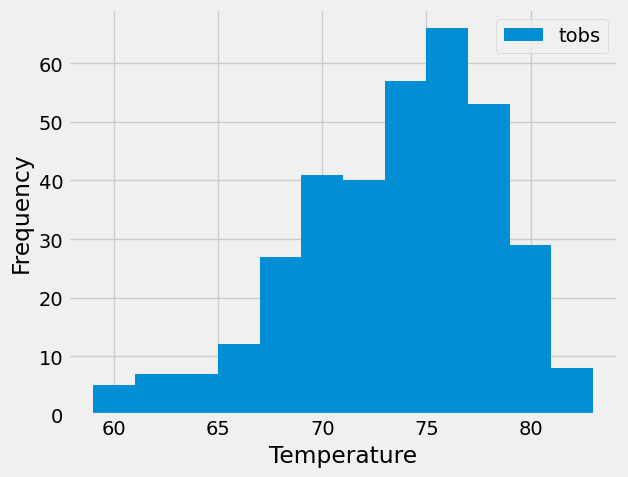

In [32]:

#  full_station_activity_df


plt.figure(figsize=(6.5,5))
plt.hist(full_station_activity_df['tobs'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
# plt.title(f'Station {most_active_station_id} Data')
# plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.show()

Text(0.5, 4.183333333333314, 'Temperature')

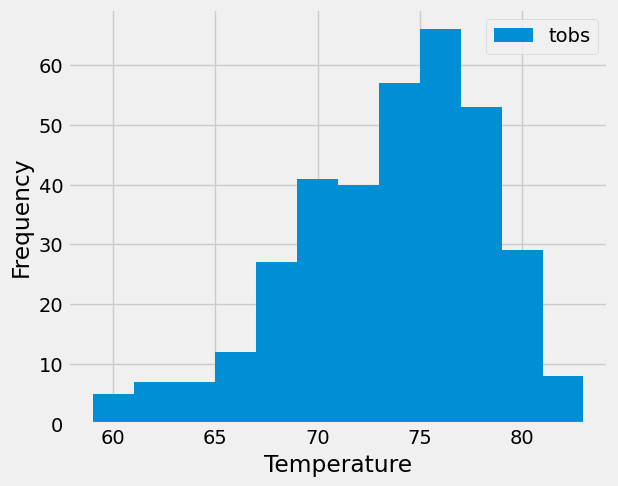

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [33]:
# Close Session
session.close()